### This notebook analyze the data for all the sensers and I look at the frequency of failure for individual sensors and try to find the edge cases. Analyzing the edge case, I aim to see what could be the potential reason failure of sensors.

FYI: 

The sensor data is extracted for past 30 days.  
We are only considering a sensor failed if we do not have data for more than 1 hour in the database 

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [75]:
import os

folder_path = 'data/'  # Replace with the actual folder path

# Get a list of all files in the folder
files = os.listdir(folder_path)

sensors = []
i = 0

dataframes = {}


for file in files:
    if file == '.DS_Store':
        pass
    else:
        name = file.replace('.csv', '')
        sensors.append(name)

        # adding data from csv file to the list of data which is placed in dataframe which is a list
        dataframes[name] = pd.read_csv('data/' + file)
%store dataframes

Stored 'dataframes' (dict)


In [76]:
print(f" We have data for {len(sensors)} sensors.")

 We have data for 52 sensors.


In [77]:
failing_detail = {} 
missing = {}
    
for i in range(len(sensors)):
    df = dataframes[sensors[i]]
    # Convert the 'time' column to datetime format (if it's not already)
    df['time'] = pd.to_datetime(df['time'])

    # Sort the DataFrame by the 'time' column
    df.sort_values('time', inplace=True)

    # Calculate the time difference between consecutive rows
    time_diff = df['time'].diff()

    # Find the indexes where the time difference is greater than one hour (3600 seconds)
    missing_indexes = time_diff[time_diff > pd.Timedelta(hours=1)].index

    missing[sensors[i]] = missing_indexes

    num = len(missing_indexes)
    
    # maintaining recored of failure for analysis
    failing_detail[sensors[i]] = num   
   

<AxesSubplot:>

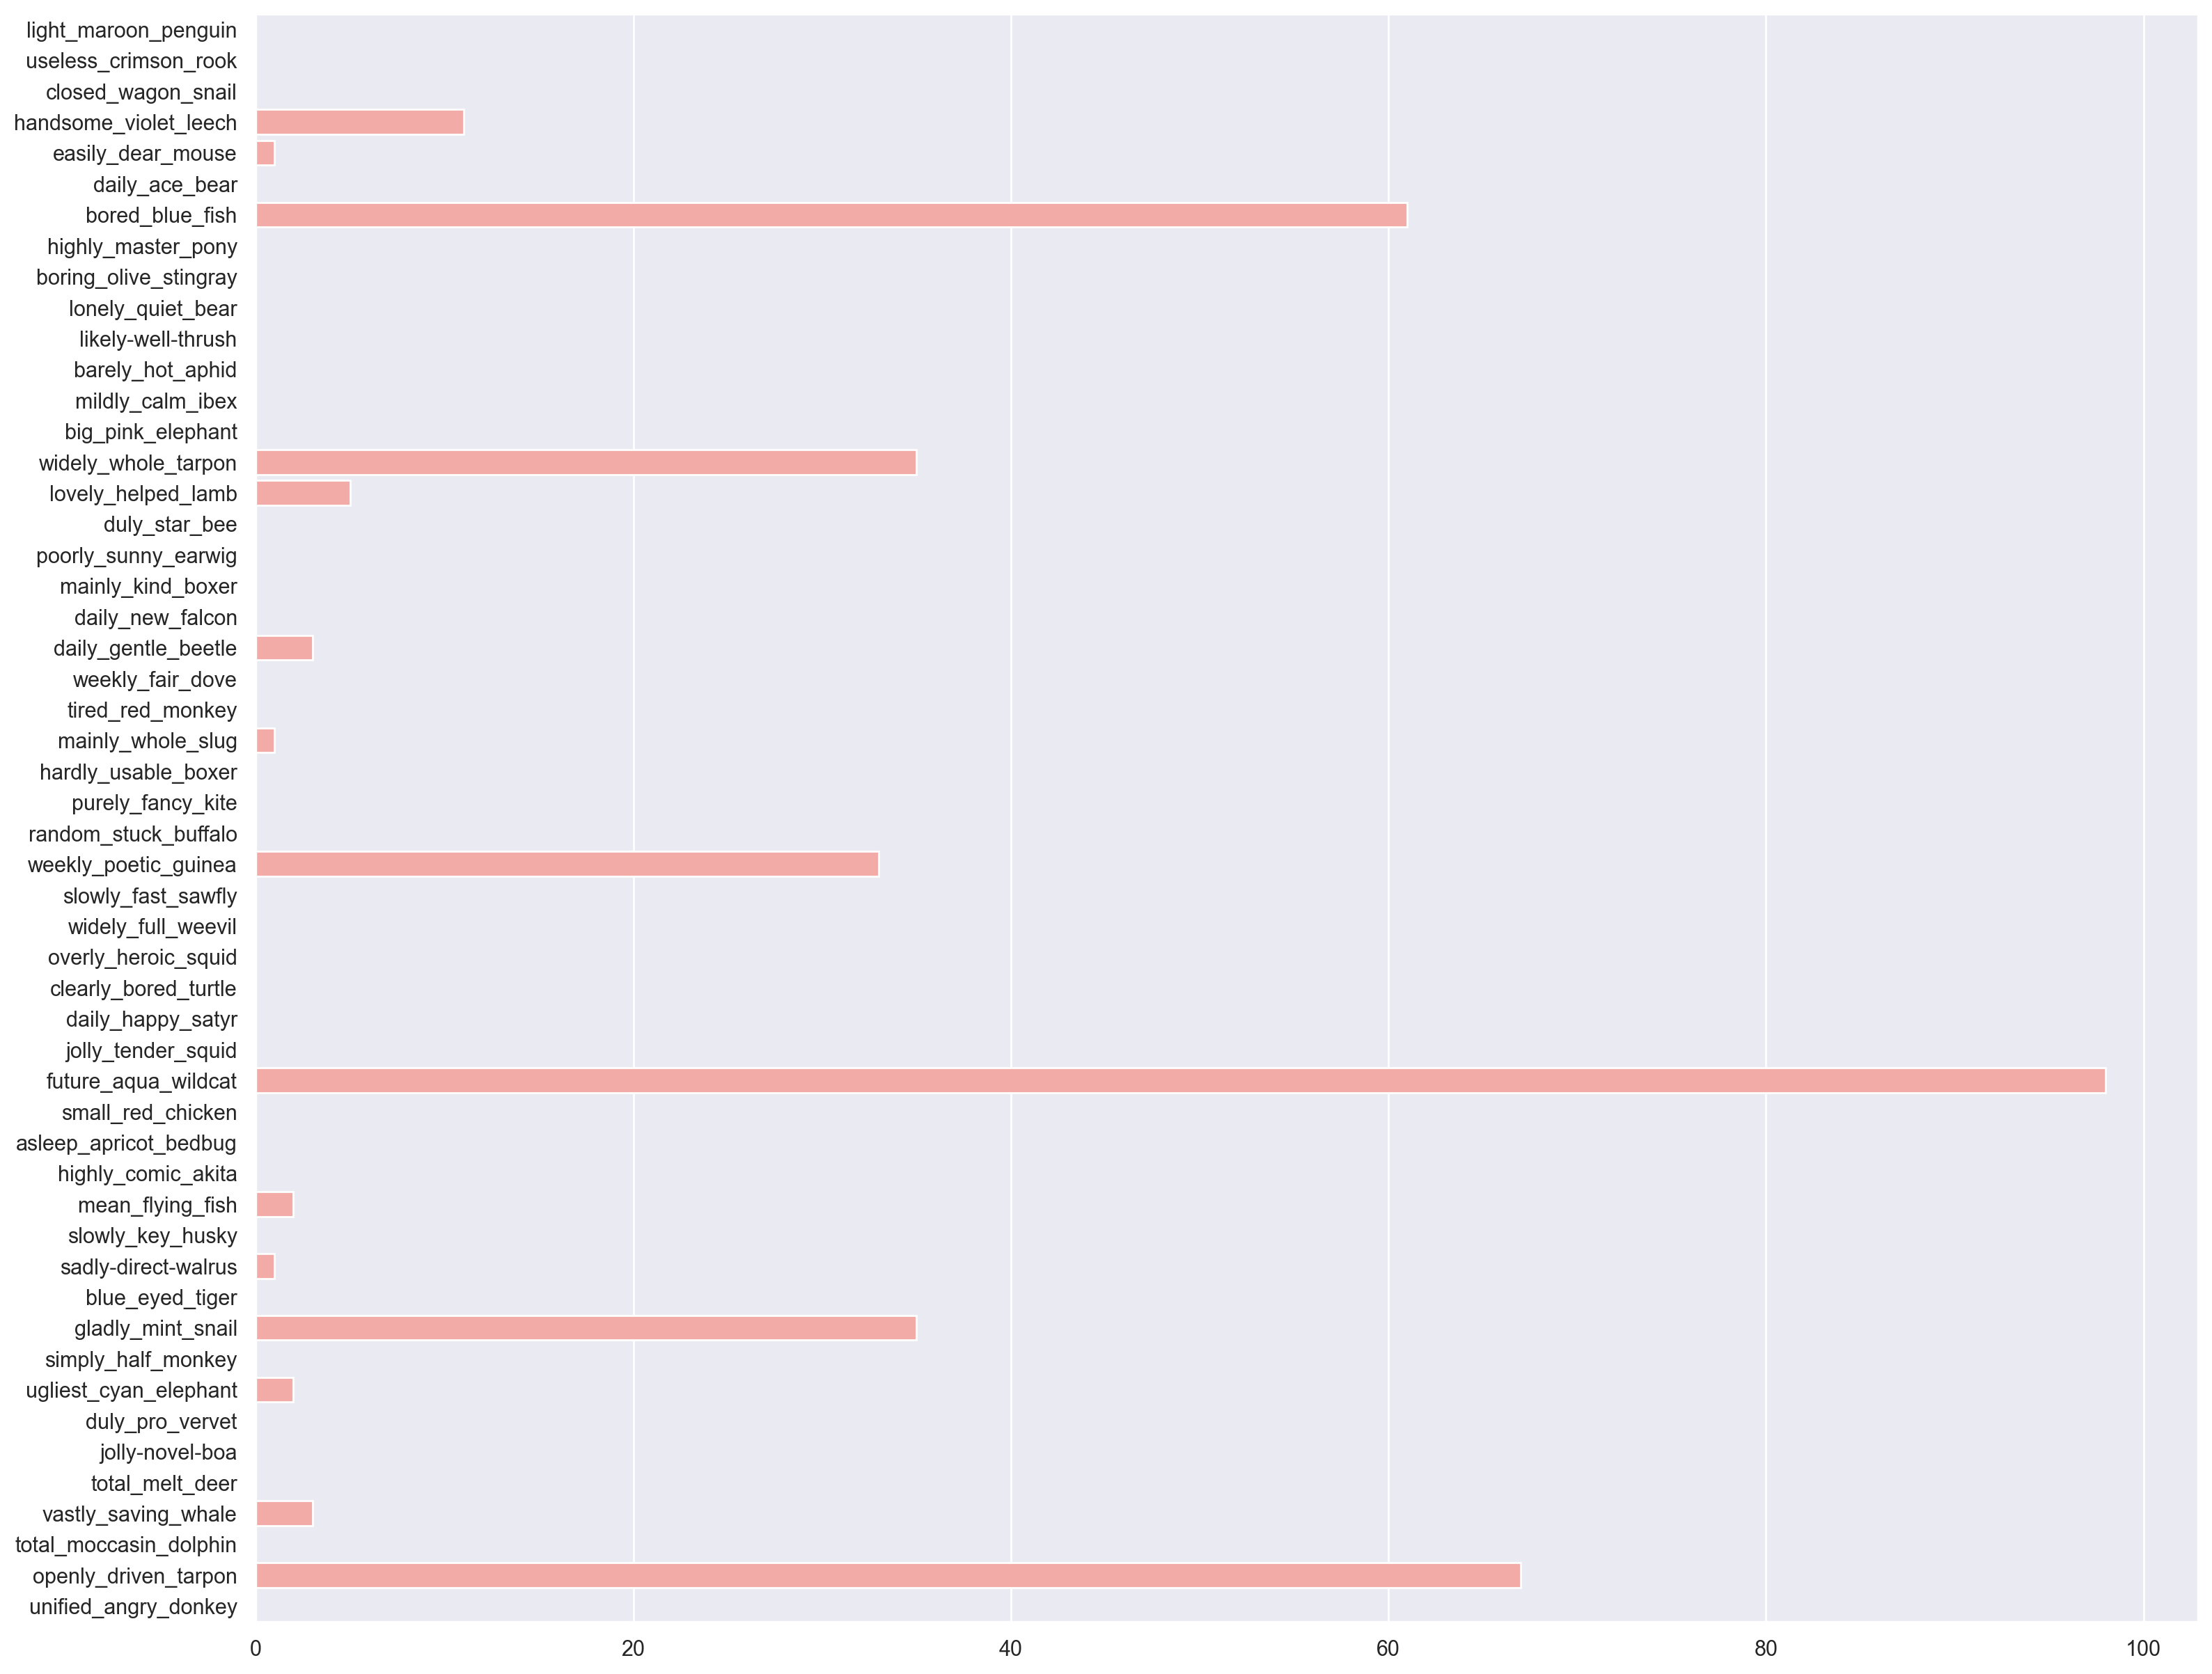

In [78]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(18,15)})
%config InlineBackend.figure_format = 'retina'

# plotting bar graph to see the frequency of failure for individual sensors

labels = list(failing_detail.keys())
heights = list(failing_detail.values())

sns.set_color_codes("pastel")
sns.barplot(x=heights, y=labels,
            label="Total", color="r", orient = 'h')

<AxesSubplot:ylabel='Count'>

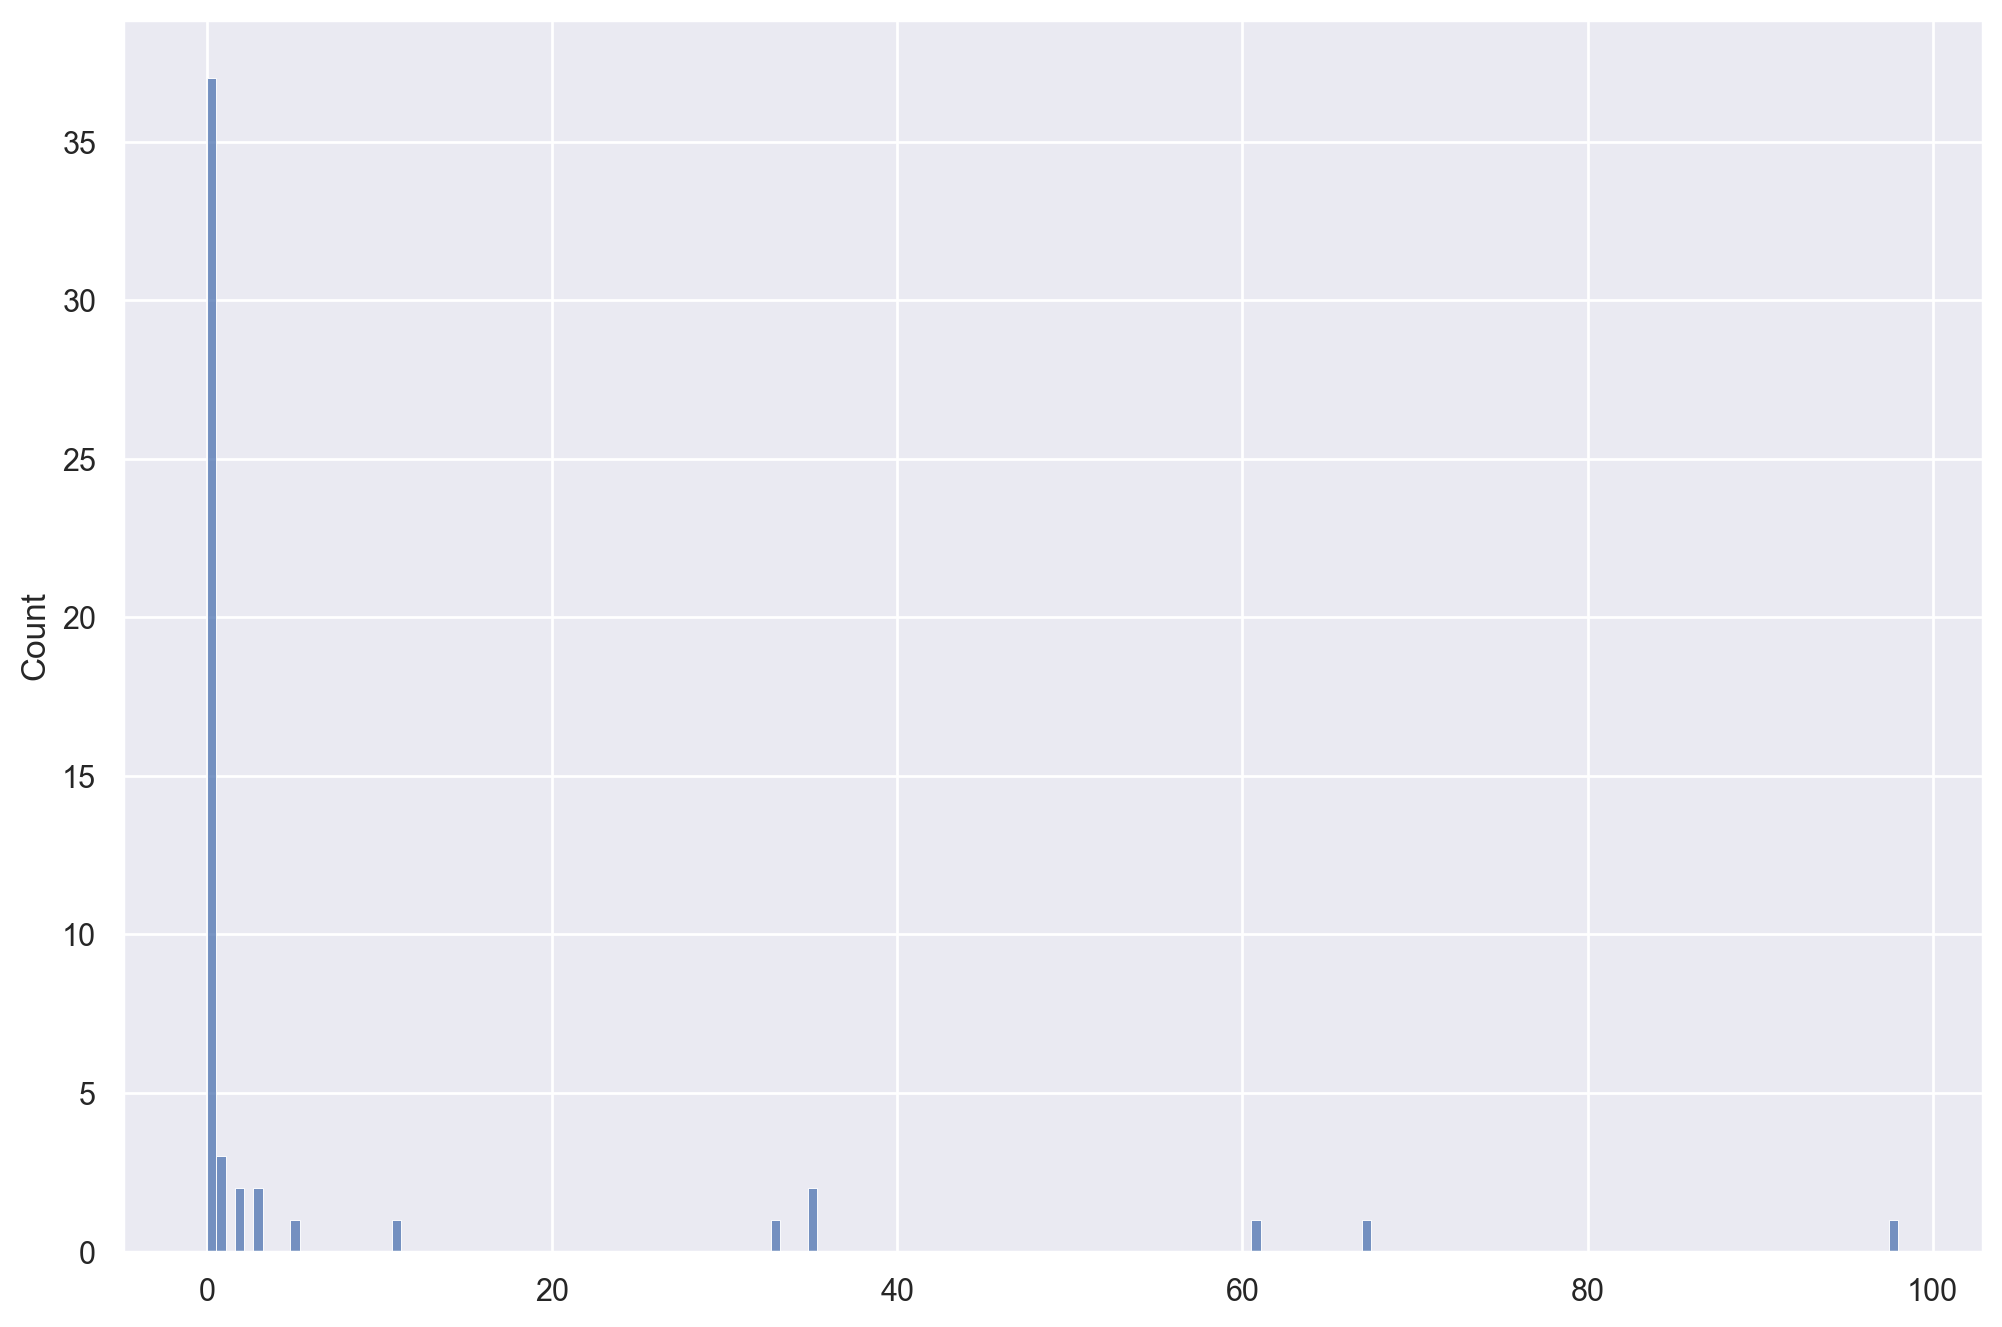

In [79]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.histplot(heights)

It seems that most of the sensor failed only a few times but there are quite a few sensors that failed for 20+. times in last 30 days. It would be interesting to see their data and see what could be reason for that failure.

In [80]:
# getting the list of sensors that has failed more more than x times and the indexes associated with that failure

interested_frequency = 20
mostly_failing_data = {}

for key, value in failing_detail.items():
    if value >=interested_frequency:
        mostly_failing_data[key] = missing[key]
        

In [81]:
len(mostly_failing_data)

6

### Analyzing data for battery voltage

So, I am trying to grab 2 data points before and after the failure of the sensor and see if there is any alarming value in battery voltage. 

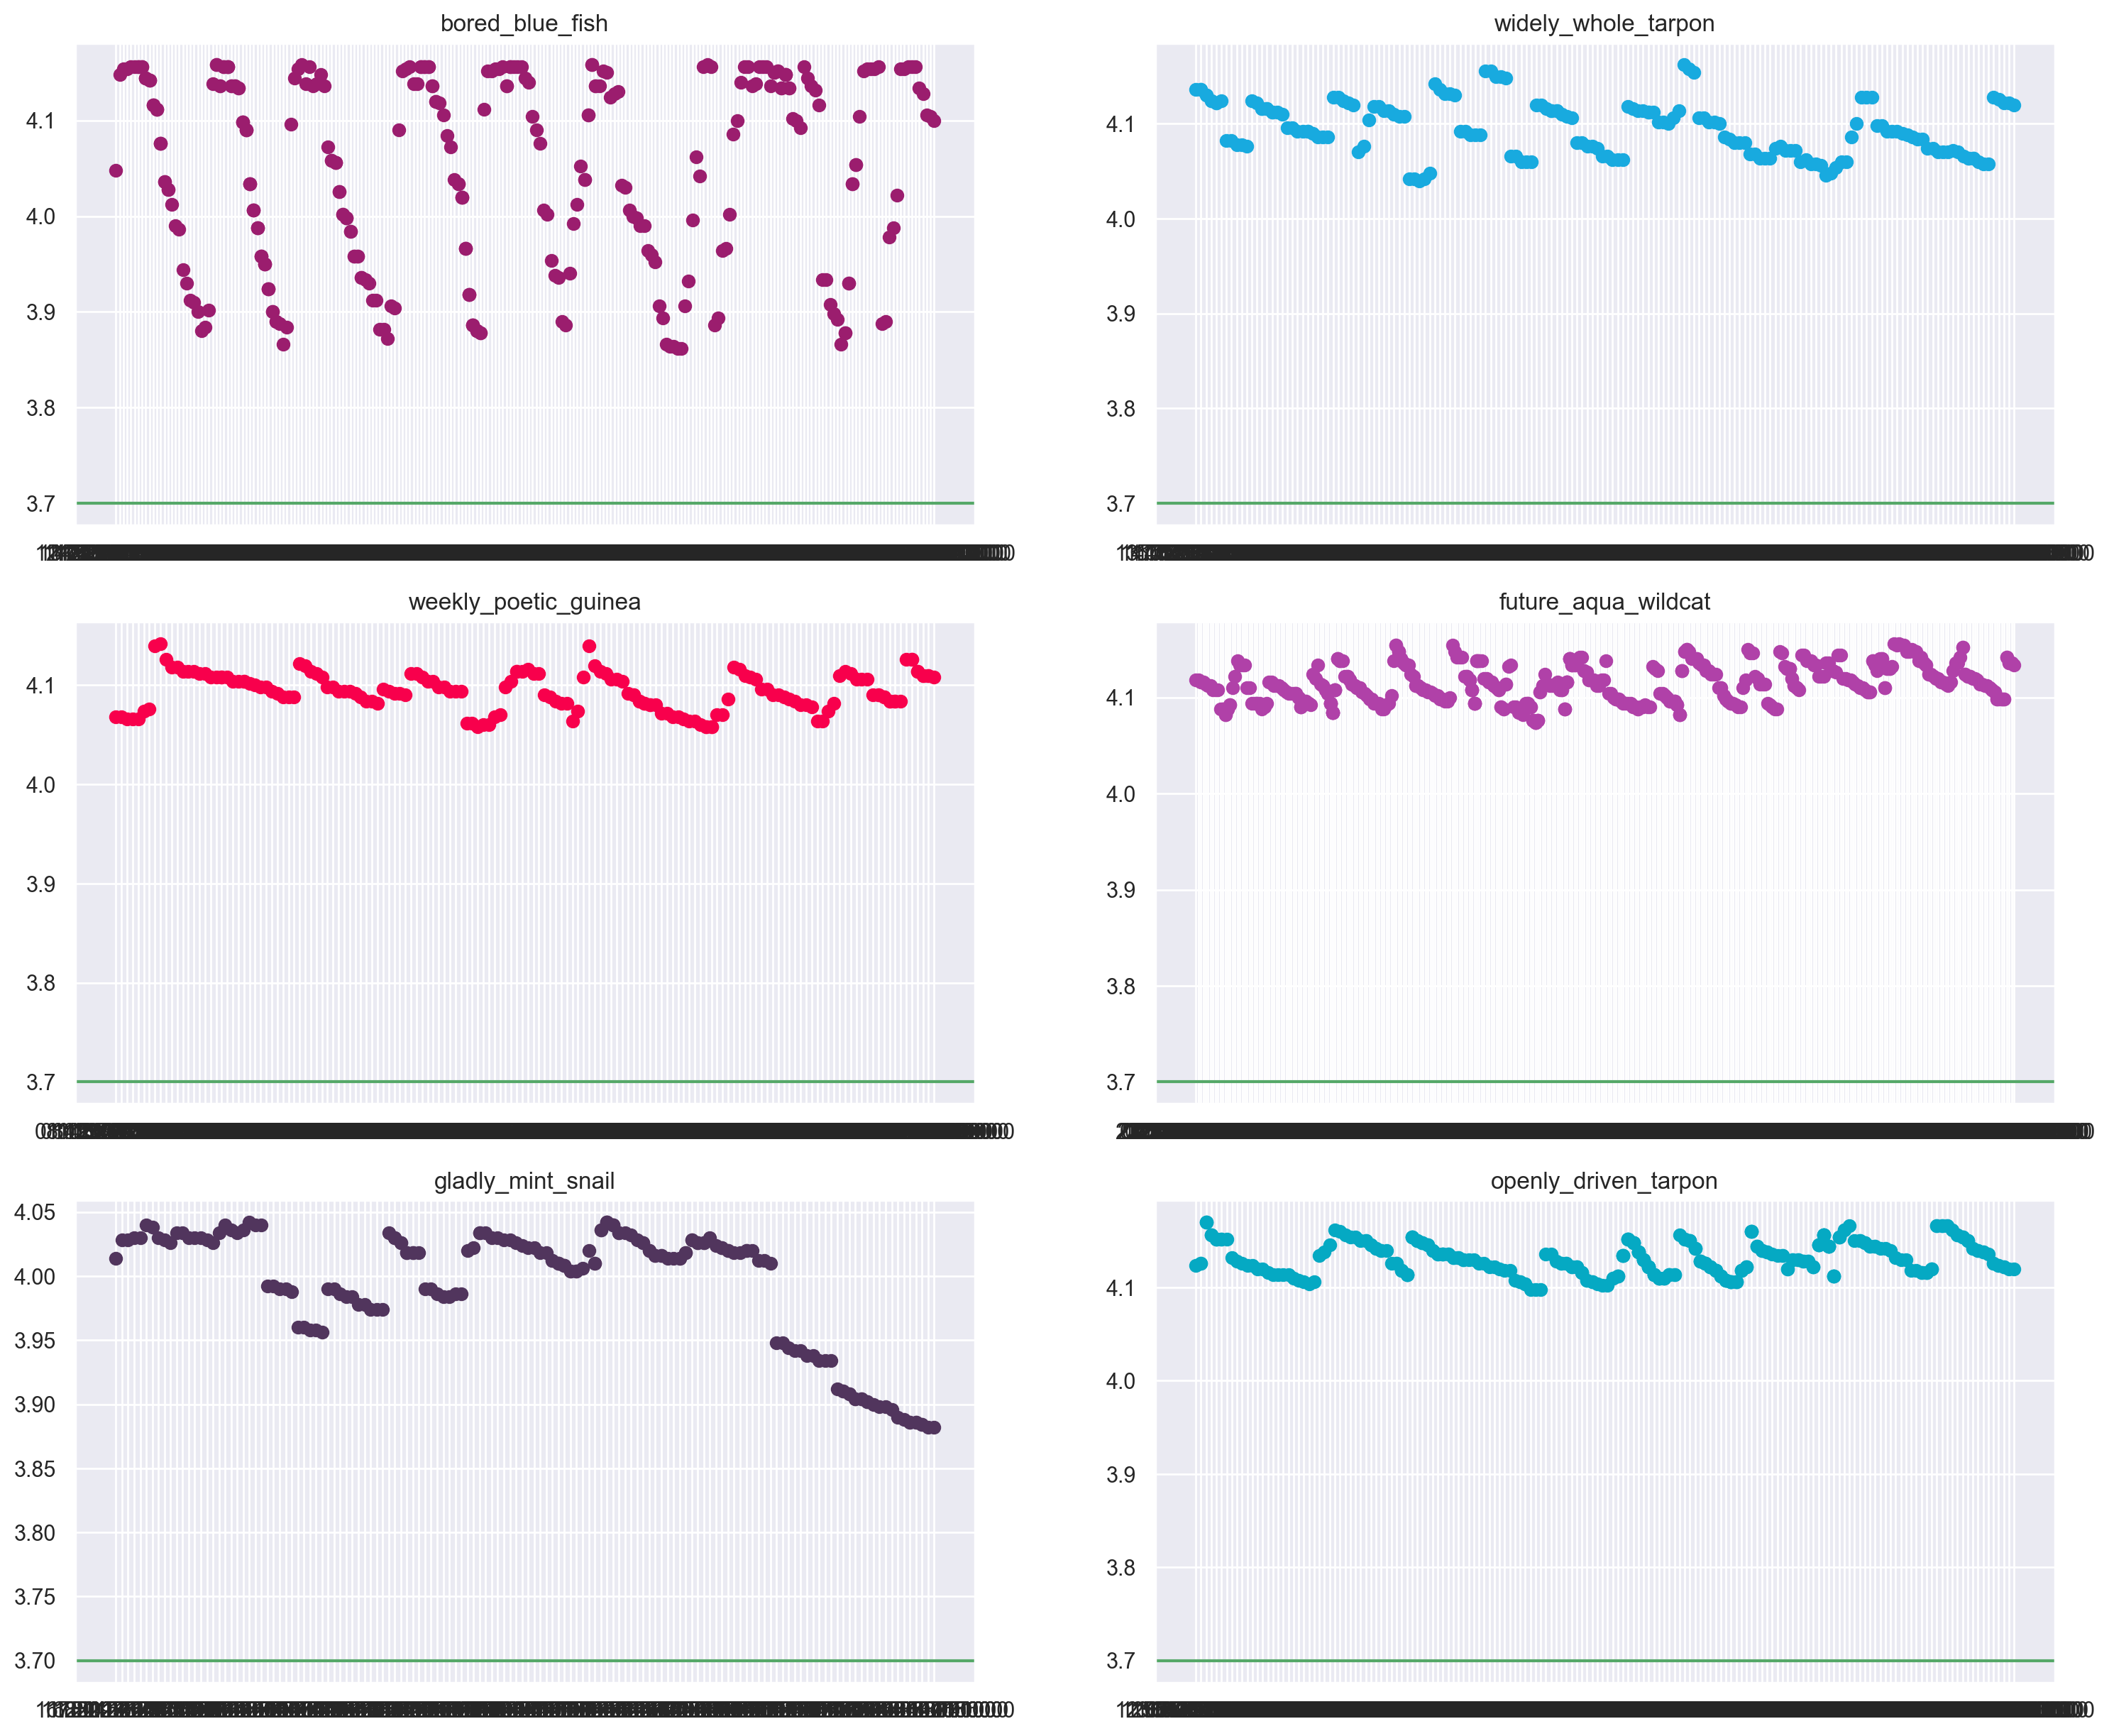

In [82]:
sns.set(rc = {'figure.figsize':(18,15)})
i = 1

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(3,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['batt_v'], color=np.random.rand(3,))
    plt.axhline(y=3.7, color = 'g')
    i += 1
plt.show()

## Observation:
It seems that battery voltage is not the reason of failure for sensors that failed more than 20 times. The reason is something else probably the gateway

### Now looking at other sensors

In [83]:
interested_frequency = 20
less_failing_data = {}

for key, value in failing_detail.items():
    if value > 0 and value < interested_frequency:
        less_failing_data[key] = missing[key]
print(len(less_failing_data))      

9


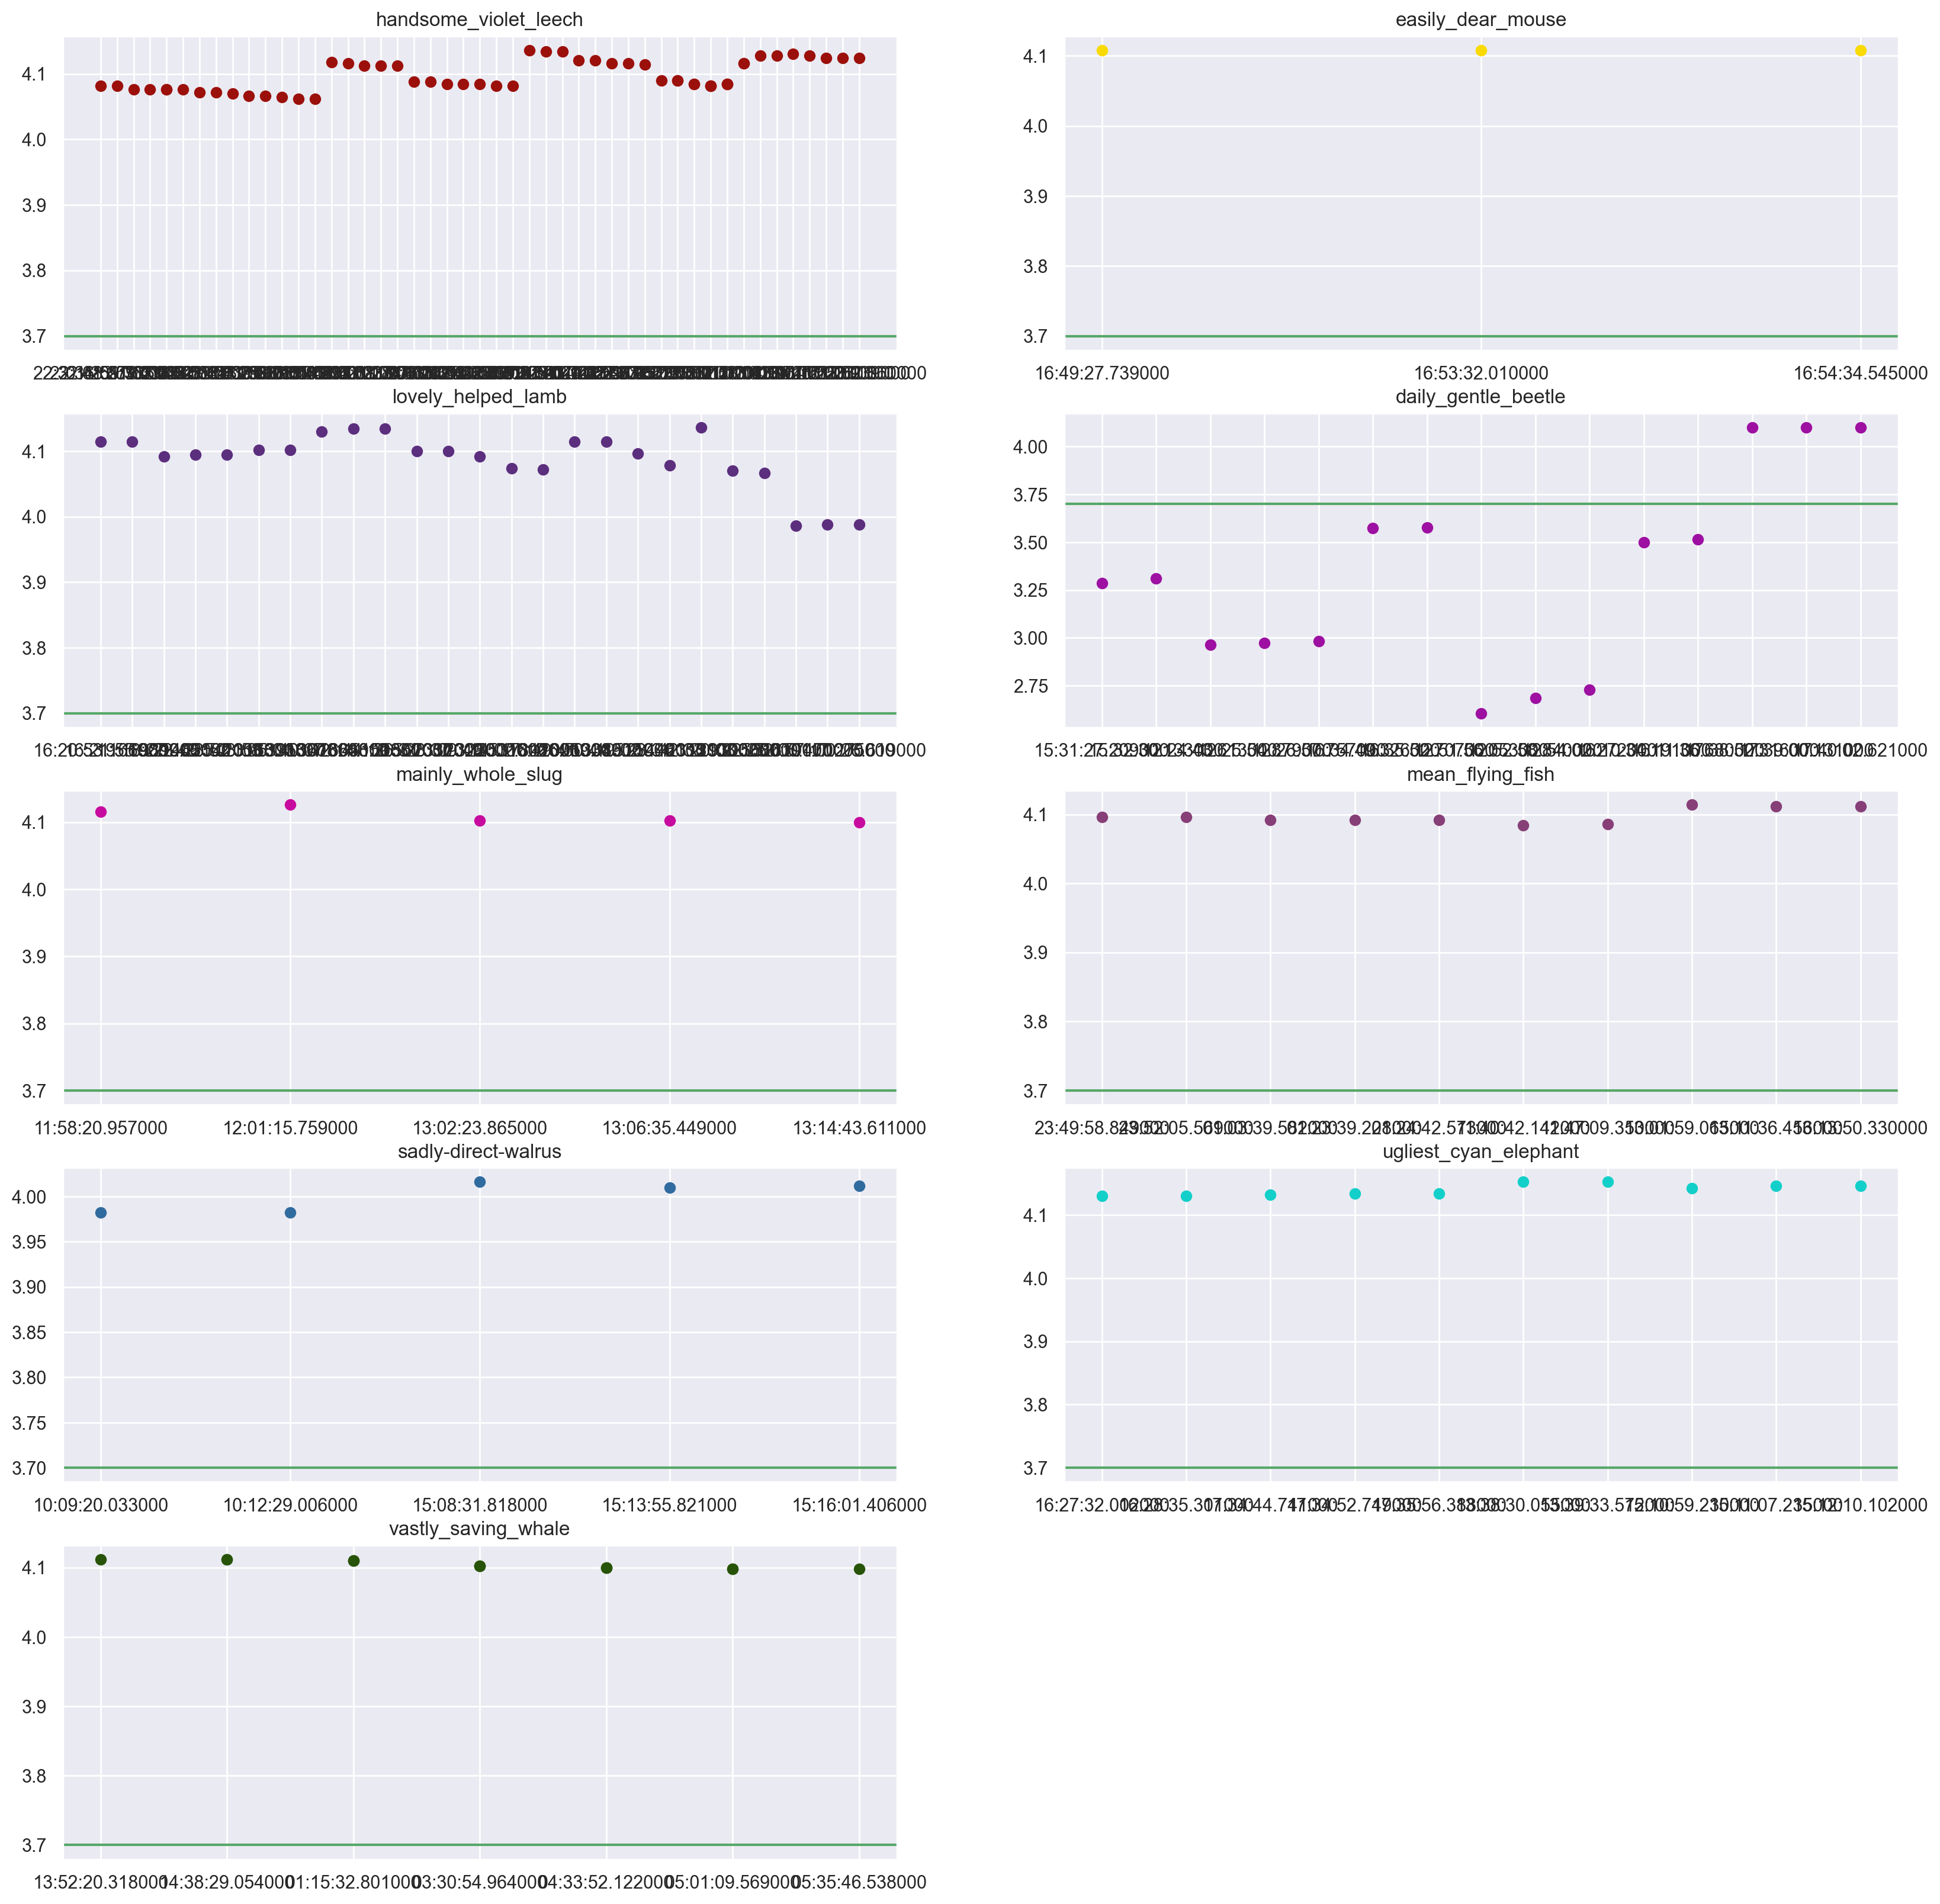

In [84]:
sns.set(rc = {'figure.figsize':(20,20)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(5,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['batt_v'], color=np.random.rand(3,))
    plt.axhline(y=3.7, color = 'g')
    i += 1

## Doing Same analysis for RSSI

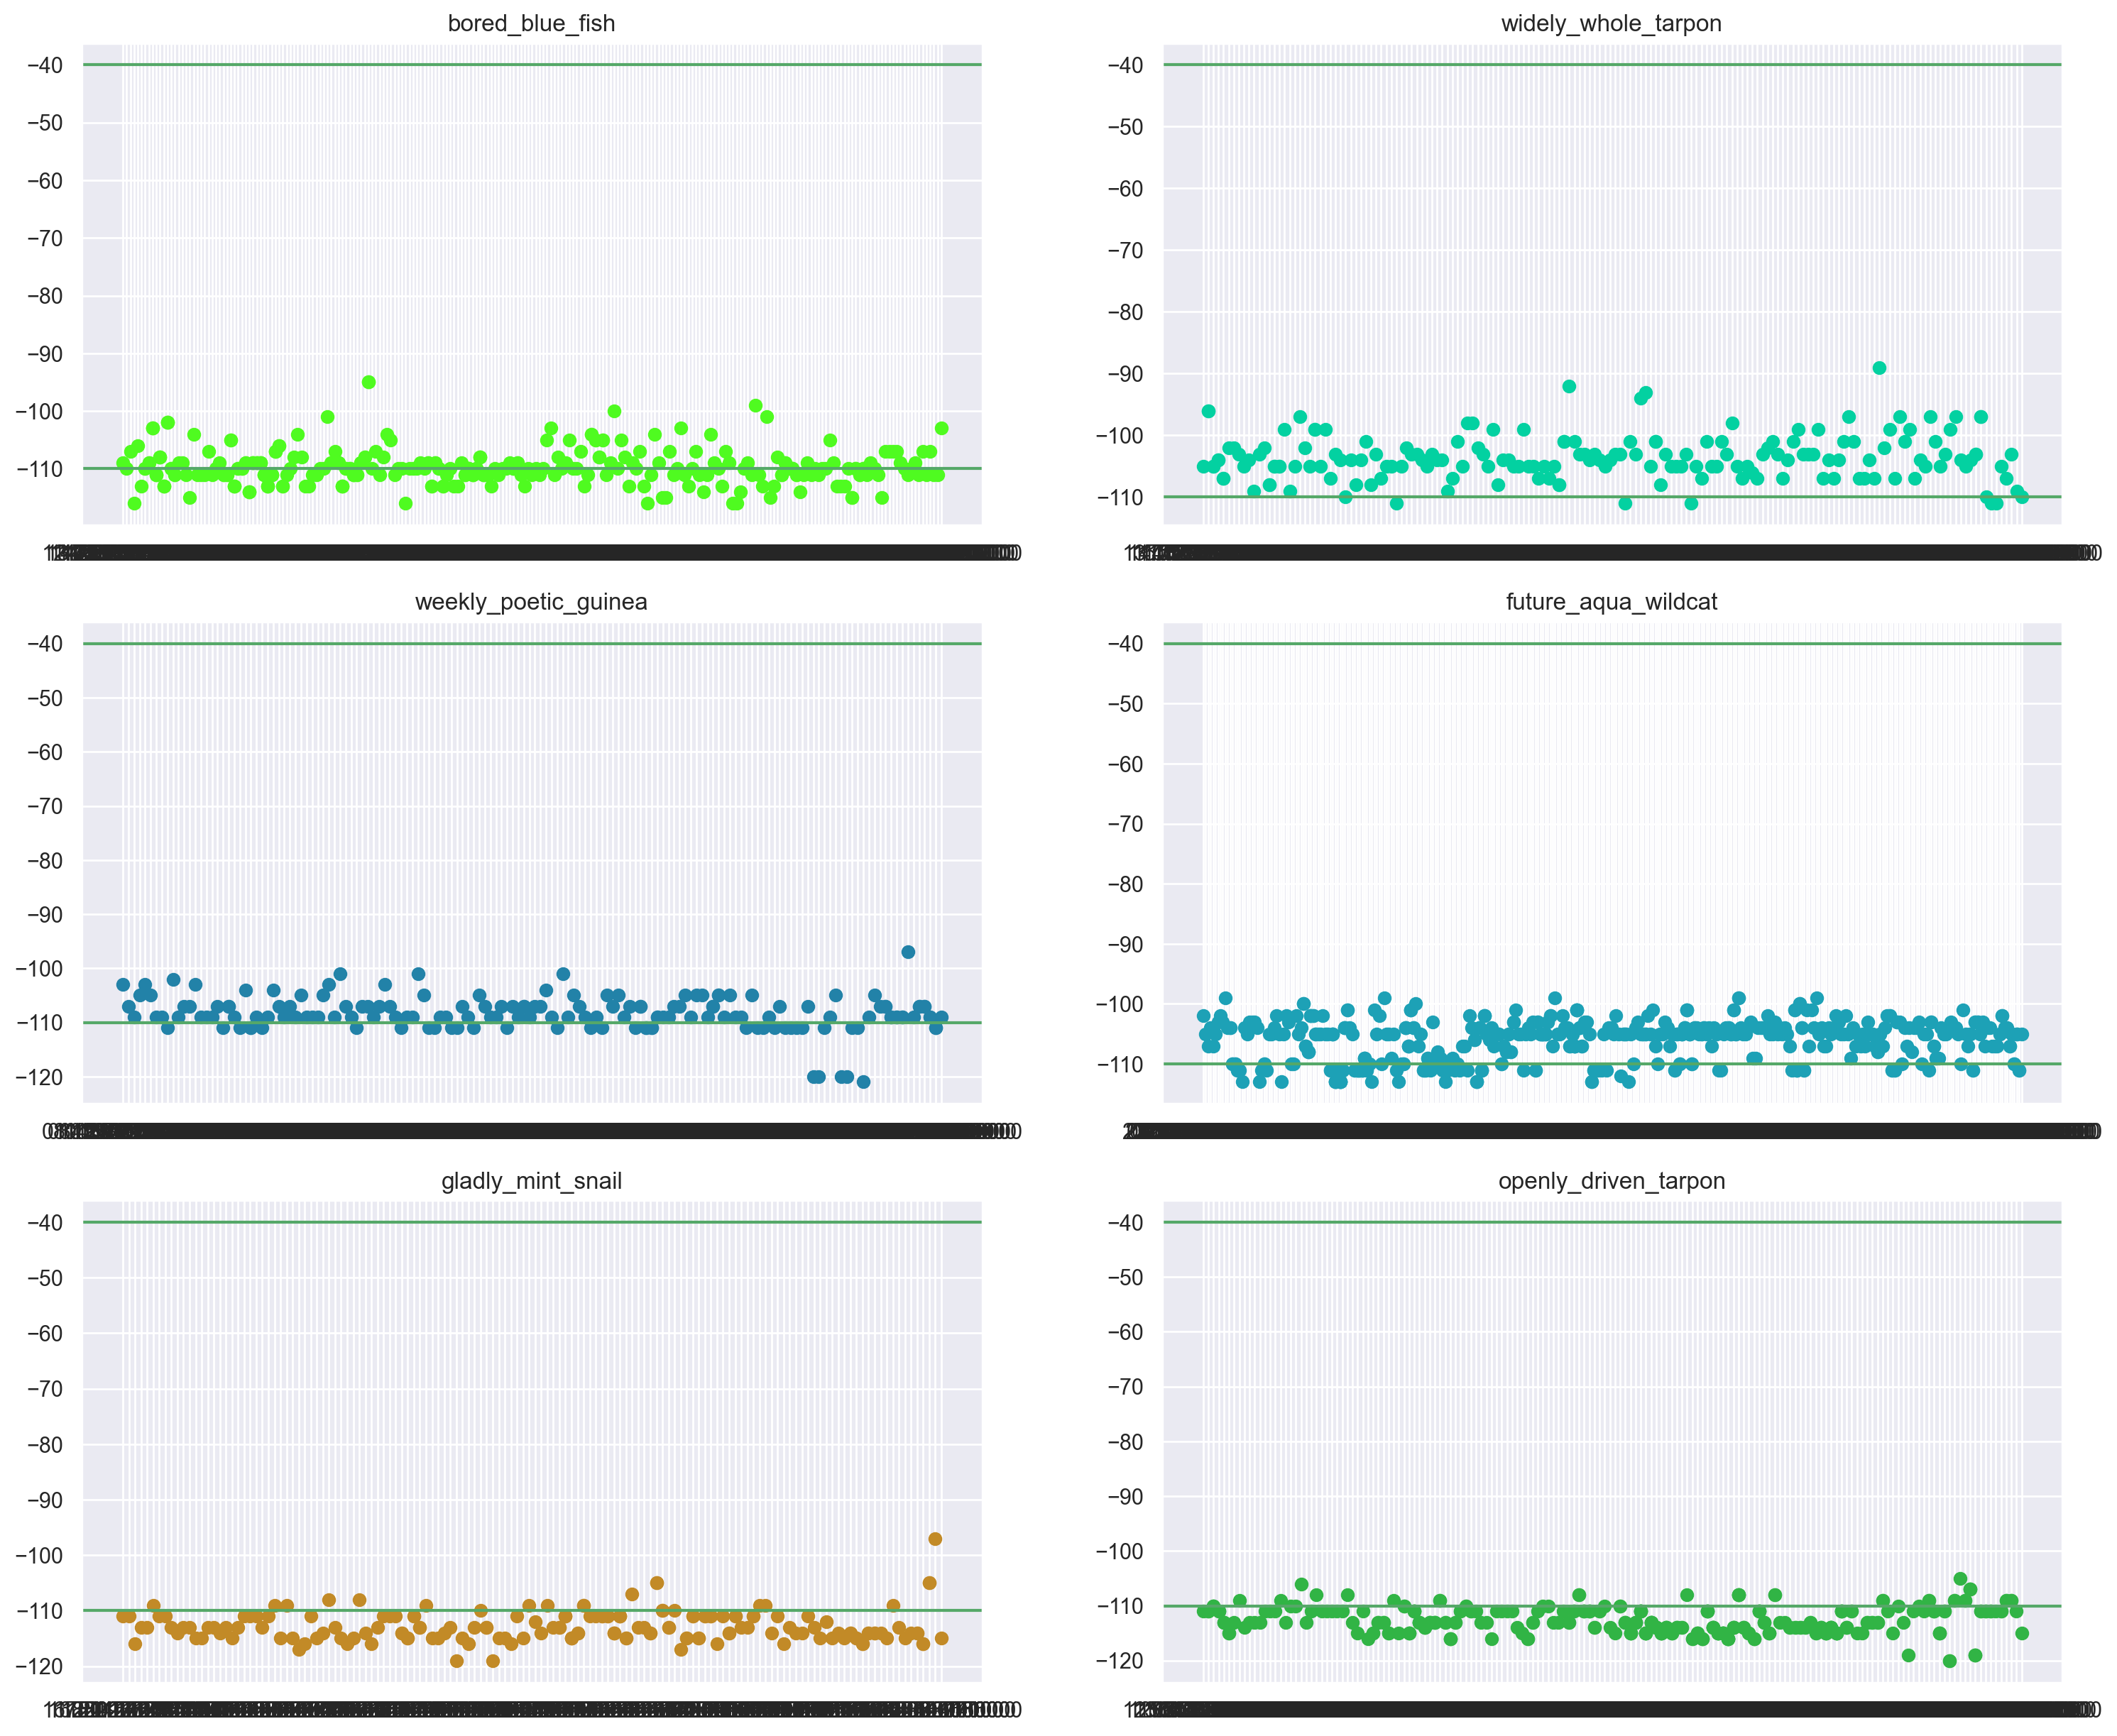

In [85]:
sns.set(rc = {'figure.figsize':(18,15)})
i = 1

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(3,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['gw_1_rssi_dbm'], color=np.random.rand(3,))
    plt.axhline(y=-40, color = 'g')
    plt.axhline(y=-110, color = 'g')
    i += 1
plt.show()

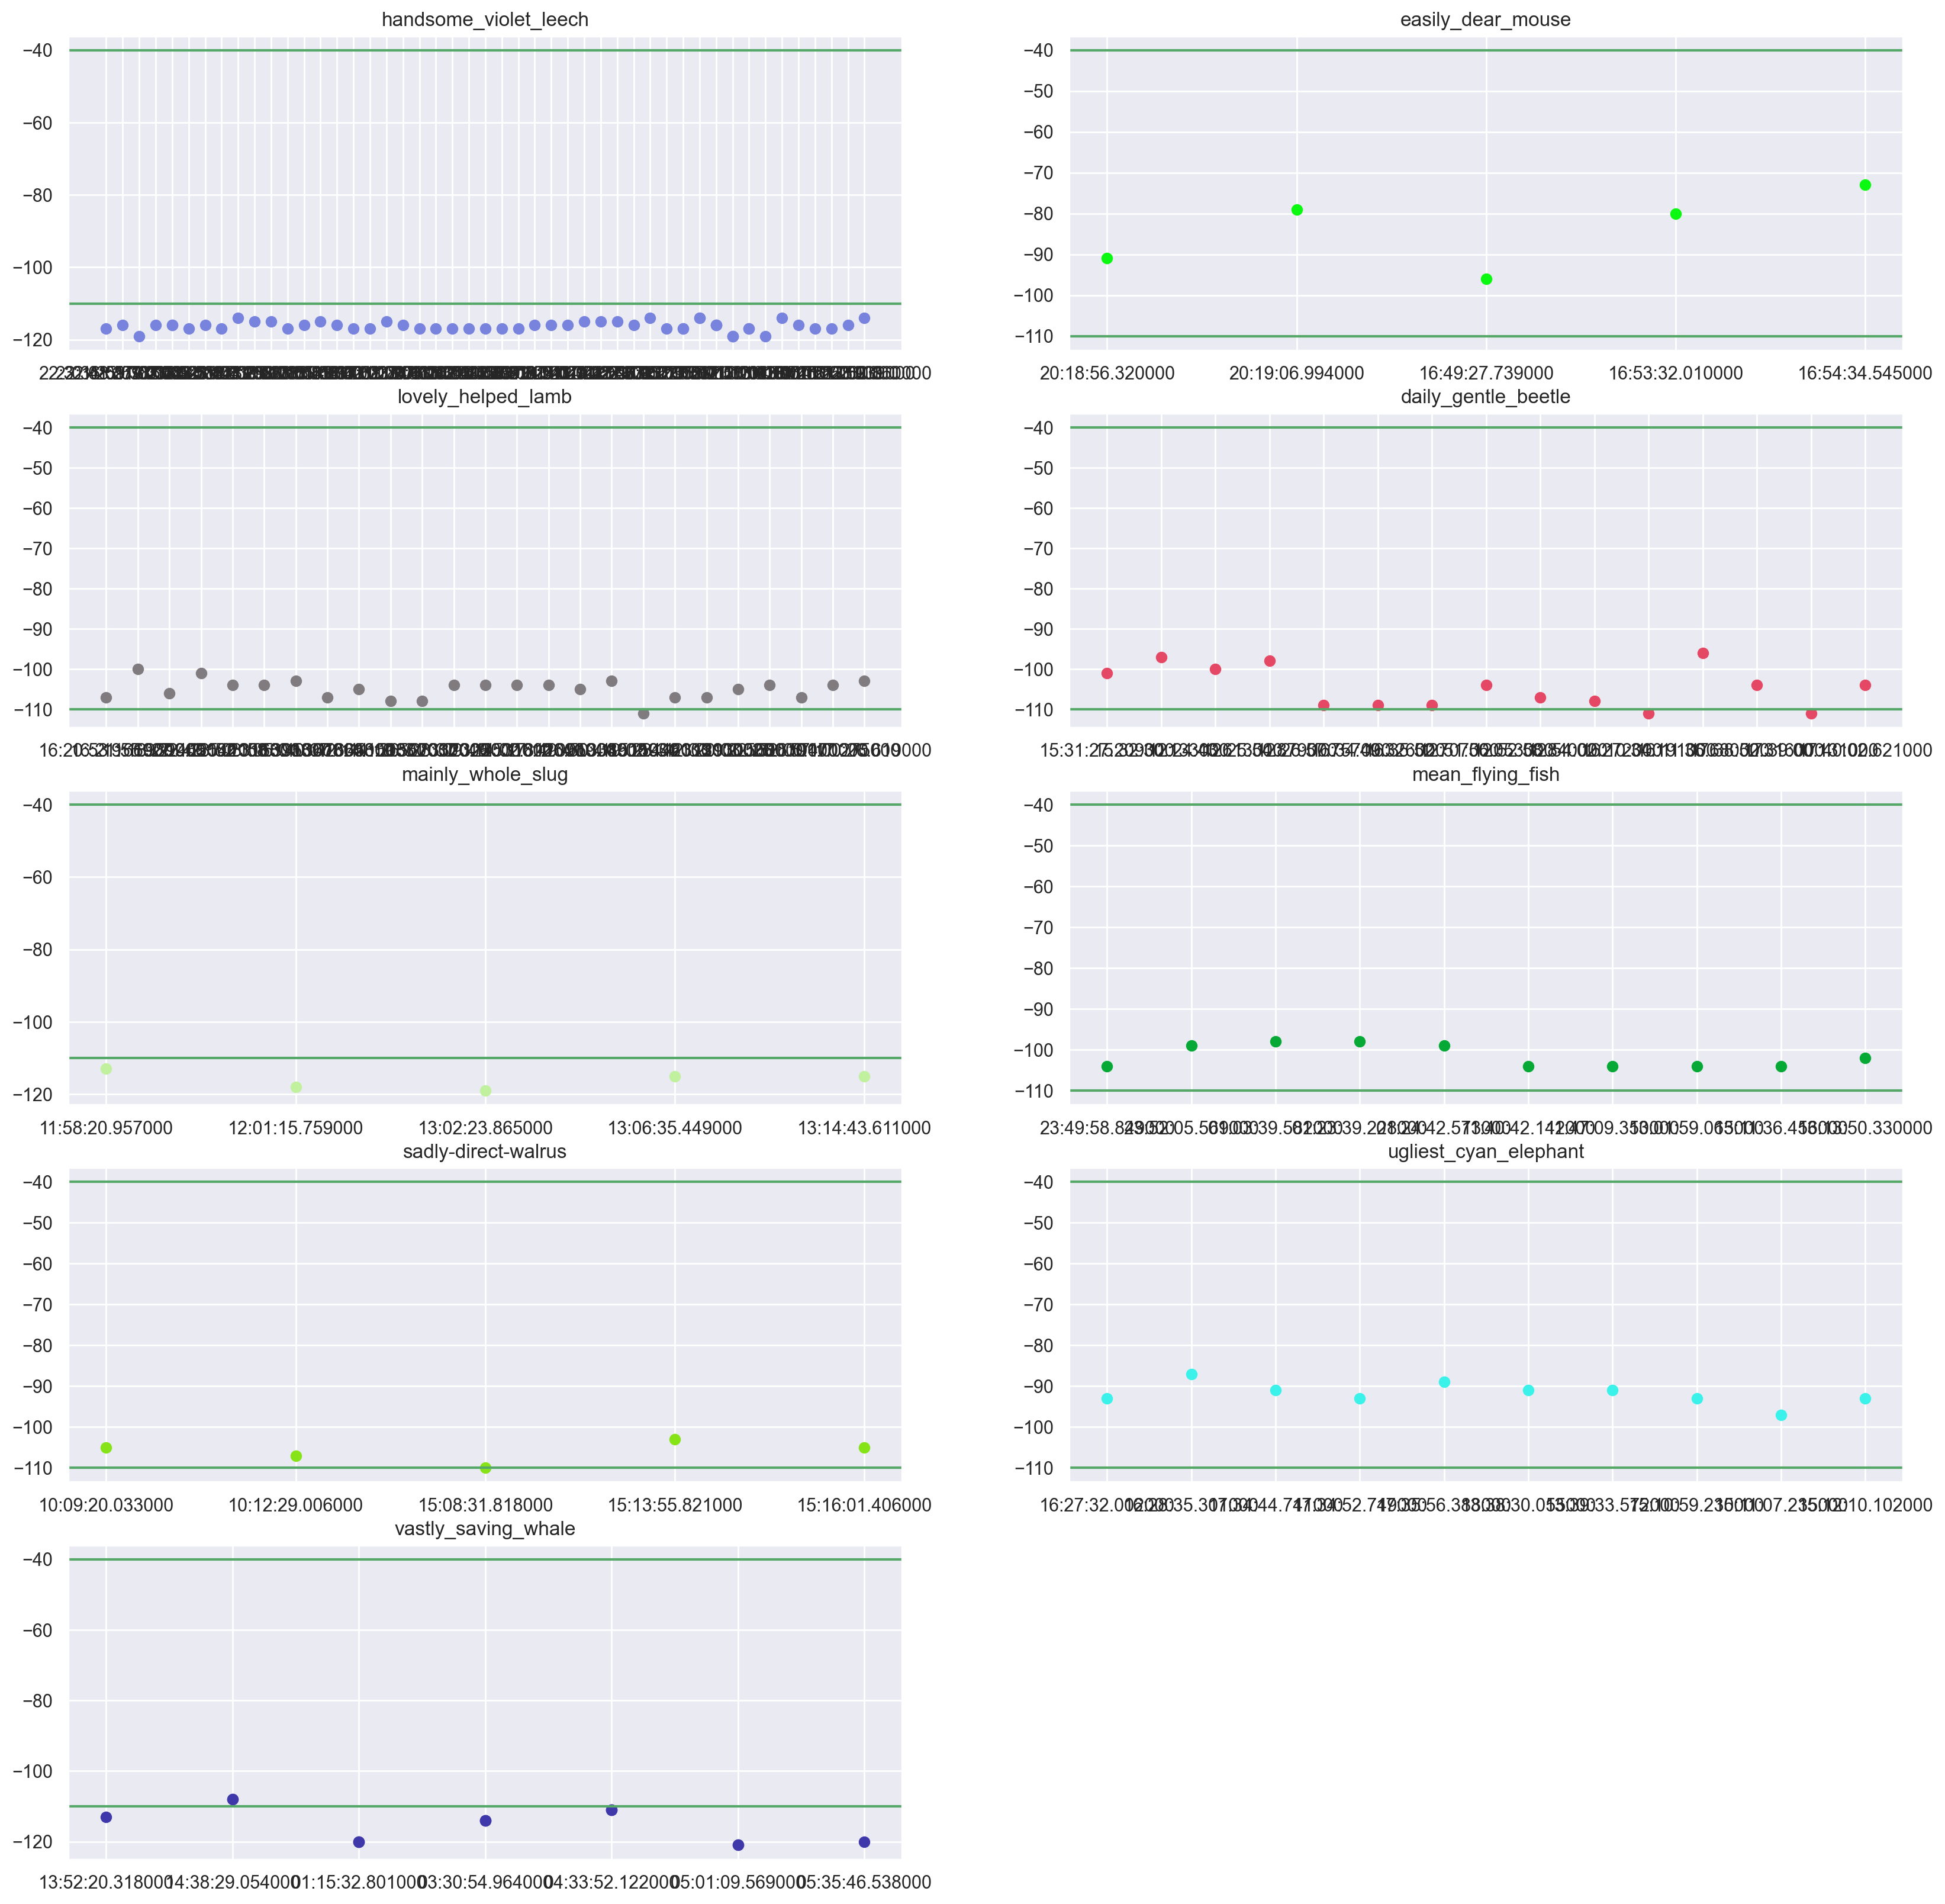

In [86]:
sns.set(rc = {'figure.figsize':(20,20)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(5,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['gw_1_rssi_dbm'], color=np.random.rand(3,))
    plt.axhline(y=-40, color = 'g')
    plt.axhline(y=-110, color = 'g')
    i += 1

In [87]:
# looking into data for weird daily_gentle_beetle
index = list(less_failing_data['daily_gentle_beetle'])
interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
dfs = dataframes['daily_gentle_beetle']
dfs.loc[interested_index].sort_values('Unnamed: 0')

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
14,14,2023-06-05 15:31:27.209000+00:00,daily_gentle_beetle,0,3.286,floodnet-lr9-gw-3235313229006900,2731,15.0,-101,3.00,15:31:27.209000,2023-06-05
15,15,2023-06-05 15:32:30.133000+00:00,daily_gentle_beetle,0,3.310,floodnet-lr9-gw-3235313229006900,2733,16.0,-97,-3.75,15:32:30.133000,2023-06-05
16,16,2023-06-08 12:24:43.613000+00:00,daily_gentle_beetle,0,2.964,floodnet-lr9-gw-3235313229006900,2734,NaN,-100,-5.50,12:24:43.613000,2023-06-08
17,17,2023-06-08 12:25:54.879000+00:00,daily_gentle_beetle,0,2.974,floodnet-lr9-gw-3235313229006900,2728,2.0,-98,-7.25,12:25:54.879000,2023-06-08
18,18,2023-06-08 12:26:57.757000+00:00,daily_gentle_beetle,0,2.982,ttn-nyc-00-08-00-4a-67-fe,2728,3.0,-109,-3.50,12:26:57.757000,2023-06-08
239,239,2023-06-08 16:34:49.326000+00:00,daily_gentle_beetle,0,3.574,ttn-nyc-00-08-00-4a-67-fe,2745,241.0,-109,-5.00,16:34:49.326000,2023-06-08
240,240,2023-06-08 16:35:52.707000+00:00,daily_gentle_beetle,0,3.576,ttn-nyc-00-08-00-4a-67-fe,2743,242.0,-109,-2.00,16:35:52.707000,2023-06-08
241,241,2023-06-09 12:51:56.053000+00:00,daily_gentle_beetle,0,2.606,floodnet-lr9-gw-3235313229006900,2734,NaN,-104,-3.25,12:51:56.053000,2023-06-09
242,242,2023-06-09 12:52:58.840000+00:00,daily_gentle_beetle,0,2.686,mikrotik-003300,2734,1.0,-107,-0.25,12:52:58.840000,2023-06-09
243,243,2023-06-09 12:54:02.272000+00:00,daily_gentle_beetle,0,2.728,ttn-nyc-00-08-00-4a-67-fe,2735,2.0,-108,-4.25,12:54:02.272000,2023-06-09


In [88]:
index = list(less_failing_data['ugliest_cyan_elephant'])
interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
dfs = dataframes['ugliest_cyan_elephant']
dfs.loc[interested_index].sort_values('Unnamed: 0')

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
17305,17305,2023-06-13 16:27:32.002000+00:00,ugliest_cyan_elephant,0,4.130,fngw-10003,1782,31.0,-93,6.50,16:27:32.002000,2023-06-13
17306,17306,2023-06-13 16:28:35.301000+00:00,ugliest_cyan_elephant,0,4.130,fngw-10003,1788,32.0,-87,8.75,16:28:35.301000,2023-06-13
17307,17307,2023-06-14 17:34:44.741000+00:00,ugliest_cyan_elephant,0,4.132,fngw-10003,1790,NaN,-91,5.00,17:34:44.741000,2023-06-14
17308,17308,2023-06-14 17:34:52.749000+00:00,ugliest_cyan_elephant,0,4.134,fngw-10003,1793,1.0,-93,6.00,17:34:52.749000,2023-06-14
17309,17309,2023-06-14 17:35:56.388000+00:00,ugliest_cyan_elephant,0,4.134,fngw-10003,1790,2.0,-89,7.75,17:35:56.388000,2023-06-14
19784,19784,2023-06-16 13:38:30.055000+00:00,ugliest_cyan_elephant,0,4.152,fngw-10003,1867,151.0,-91,6.50,13:38:30.055000,2023-06-16
19785,19785,2023-06-16 13:39:33.572000+00:00,ugliest_cyan_elephant,0,4.152,fngw-10003,1865,152.0,-91,1.50,13:39:33.572000,2023-06-16
19786,19786,2023-06-23 15:10:59.230000+00:00,ugliest_cyan_elephant,0,4.142,fngw-10003,1840,NaN,-93,4.75,15:10:59.230000,2023-06-23
19787,19787,2023-06-23 15:11:07.235000+00:00,ugliest_cyan_elephant,0,4.146,fngw-10003,1838,1.0,-97,3.50,15:11:07.235000,2023-06-23
19788,19788,2023-06-23 15:12:10.102000+00:00,ugliest_cyan_elephant,0,4.146,fngw-10003,1839,2.0,-93,7.25,15:12:10.102000,2023-06-23


In [89]:
test_6_13 = pd.DataFrame()

from datetime import date
date1 = date(2023, 6, 13)
date2 = date(2023, 6, 14)
dates = [date1, date2]

for sensor in sensors:
    df = dataframes[sensor]
    add_df = df[(df['gw_1_id'] == 'fngw-10003') & (df['time'].dt.date in dates)]
    test_6_13 = pd.concat([test_6_13, add_df], ignore_index=True)
    #print(f"added {sensor}")
    
test_6_13

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
test_6_13[test_6_13['time'].dt.hour == 15]

In [ ]:
test_sensors = list(set(test_6_13['deployment_id']))
test_sensors

In [ ]:
sns.set(rc = {'figure.figsize':(6,6)})
i = 0;
for sensor in test_sensors:
        temp = test_6_13[test_6_13['deployment_id'] == sensor]
        plt.scatter(x = temp['times'], y = [i for _ in range(temp.shape[0])], color=np.random.rand(3,))
        i += 1
        
        

In [ ]:
list(mostly_failing_data.keys()) + list(less_failing_data.keys())

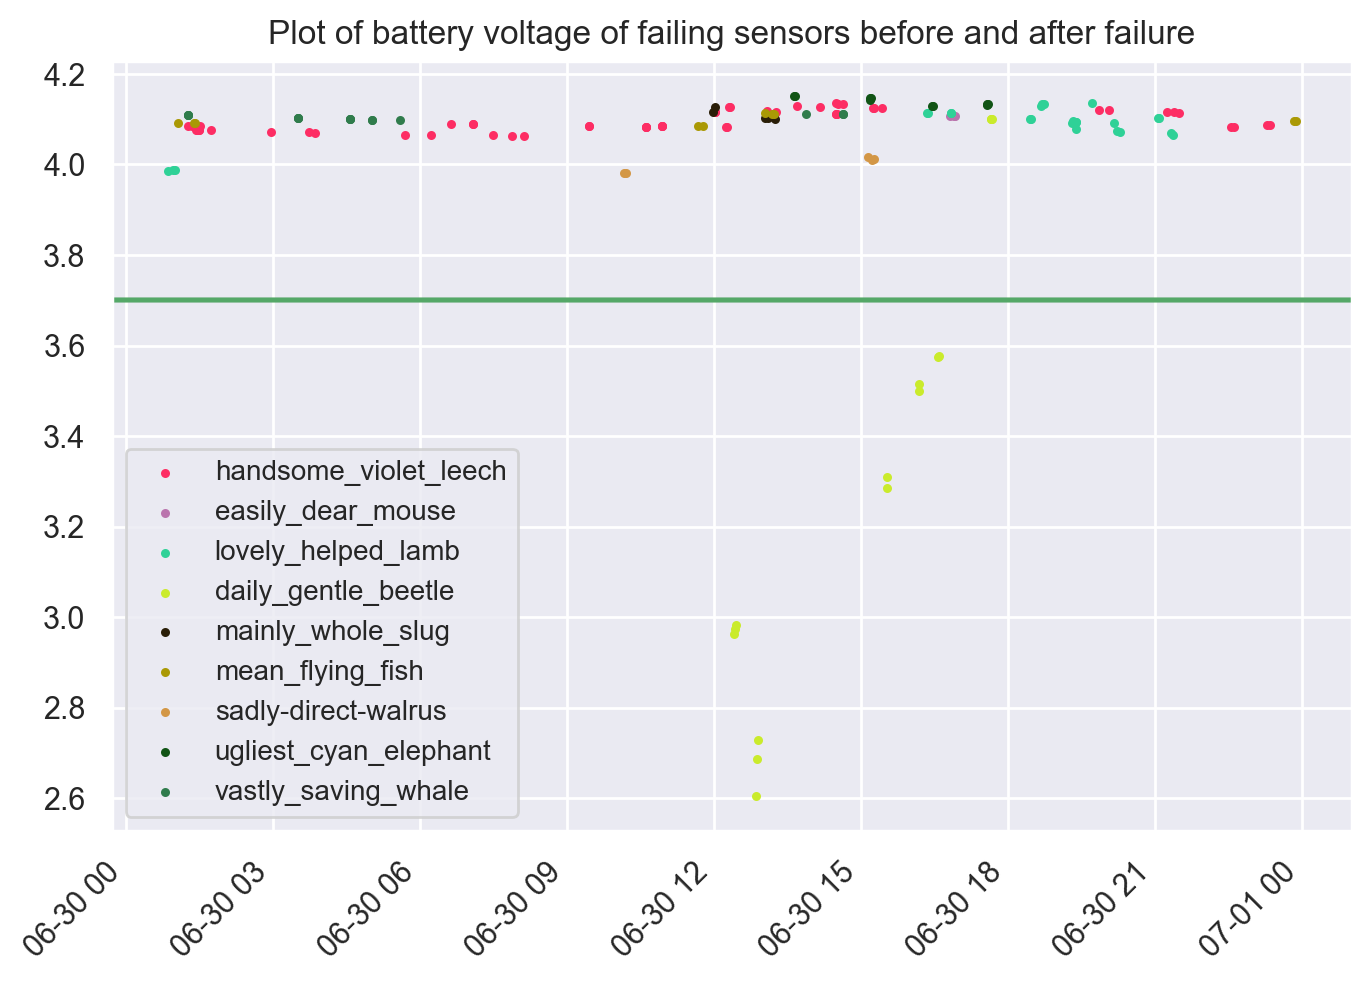

In [100]:
## plotting battery voltage data for all of the sensors

sns.set(rc = {'figure.figsize':(8,5)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    #plt.title(key)
    plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)
    plt.axhline(y=3.7, color = 'g')


# for key, values in mostly_failing_data.items():
#     index = list(values)
#     interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
#     failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
#     #plt.title(key)
#     plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)
#     plt.axhline(y=3.7, color = 'g')


plt.xticks(rotation=45, ha='right')
plt.title('Plot of battery voltage of failing sensors before and after failure')
plt.legend(fontsize='small', loc='lower left')
plt.show()

In [ ]:
pd.to_datetime(failing_df['times'])

In [101]:
failing_df

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
29691,29691,2023-06-27 13:52:20.318000+00:00,vastly_saving_whale,0,4.112,eui-343632383e001c00,2509,482959,-113,-7.00,13:52:20.318000,2023-06-27
29692,29692,2023-06-27 14:38:29.054000+00:00,vastly_saving_whale,0,4.112,eui-343632383e001c00,2508,483003,-108,-8.25,14:38:29.054000,2023-06-27
29692,29692,2023-06-27 14:38:29.054000+00:00,vastly_saving_whale,0,4.112,eui-343632383e001c00,2508,483003,-108,-8.25,14:38:29.054000,2023-06-27
29693,29693,2023-06-28 01:15:32.801000+00:00,vastly_saving_whale,0,4.110,ttn-nyc-00-08-00-4a-43-21,2508,483610,-120,-8.25,01:15:32.801000,2023-06-28
29693,29693,2023-06-28 01:15:32.801000+00:00,vastly_saving_whale,0,4.110,ttn-nyc-00-08-00-4a-43-21,2508,483610,-120,-8.25,01:15:32.801000,2023-06-28
29693,29693,2023-06-28 01:15:32.801000+00:00,vastly_saving_whale,0,4.110,ttn-nyc-00-08-00-4a-43-21,2508,483610,-120,-8.25,01:15:32.801000,2023-06-28
29694,29694,2023-06-28 03:30:54.964000+00:00,vastly_saving_whale,0,4.102,eui-343632383e001c00,2503,483739,-114,-7.75,03:30:54.964000,2023-06-28
29694,29694,2023-06-28 03:30:54.964000+00:00,vastly_saving_whale,0,4.102,eui-343632383e001c00,2503,483739,-114,-7.75,03:30:54.964000,2023-06-28
29694,29694,2023-06-28 03:30:54.964000+00:00,vastly_saving_whale,0,4.102,eui-343632383e001c00,2503,483739,-114,-7.75,03:30:54.964000,2023-06-28
29695,29695,2023-06-28 04:33:52.122000+00:00,vastly_saving_whale,0,4.100,eui-343632383e001c00,2500,483799,-111,-7.00,04:33:52.122000,2023-06-28


In [ ]:
pd.to_datetime(

In [103]:
less_failing_data

{'handsome_violet_leech': Int64Index([23679, 23683, 23699, 23740, 23804, 23871, 23924, 24148, 24149,
             24151, 24173],
            dtype='int64'),
 'easily_dear_mouse': Int64Index([8], dtype='int64'),
 'lovely_helped_lamb': Int64Index([478, 2279, 10037, 10618, 11827], dtype='int64'),
 'daily_gentle_beetle': Int64Index([16, 241, 409], dtype='int64'),
 'mainly_whole_slug': Int64Index([957], dtype='int64'),
 'mean_flying_fish': Int64Index([15546, 15593], dtype='int64'),
 'sadly-direct-walrus': Int64Index([14859], dtype='int64'),
 'ugliest_cyan_elephant': Int64Index([17307, 19786], dtype='int64'),
 'vastly_saving_whale': Int64Index([29693, 29694, 29695], dtype='int64')}

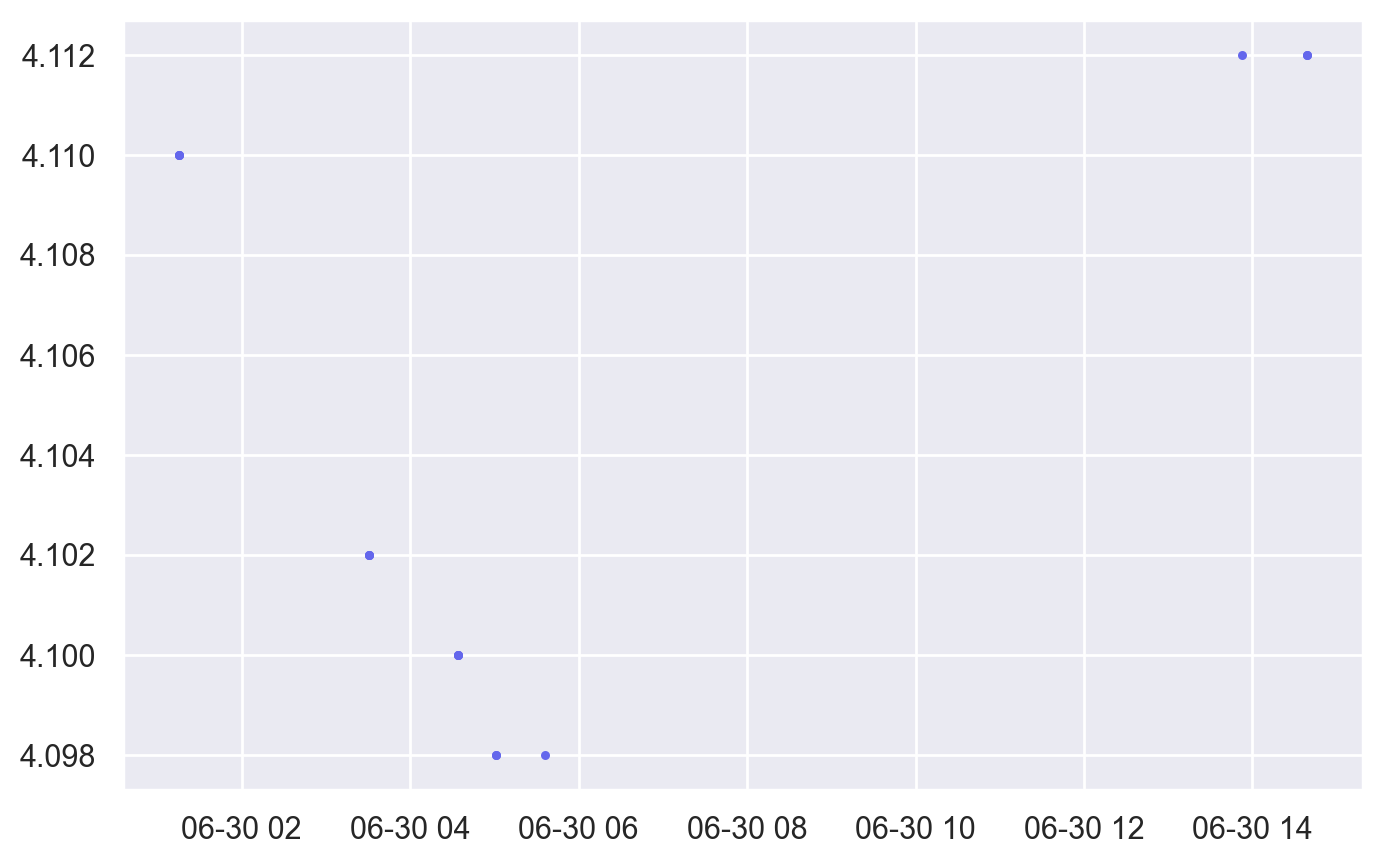

In [104]:
plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)

In [109]:
lis = []
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    lis.append(failing_df)

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    lis.append(failing_df)

big_fail = pd.concat(lis)
{i for i in big_fail['deployment_id']}

{'bored_blue_fish',
 'daily_gentle_beetle',
 'easily_dear_mouse',
 'future_aqua_wildcat',
 'gladly_mint_snail',
 'handsome_violet_leech',
 'lovely_helped_lamb',
 'mainly_whole_slug',
 'mean_flying_fish',
 'openly_driven_tarpon',
 'sadly-direct-walrus',
 'ugliest_cyan_elephant',
 'vastly_saving_whale',
 'weekly_poetic_guinea',
 'widely_whole_tarpon'}

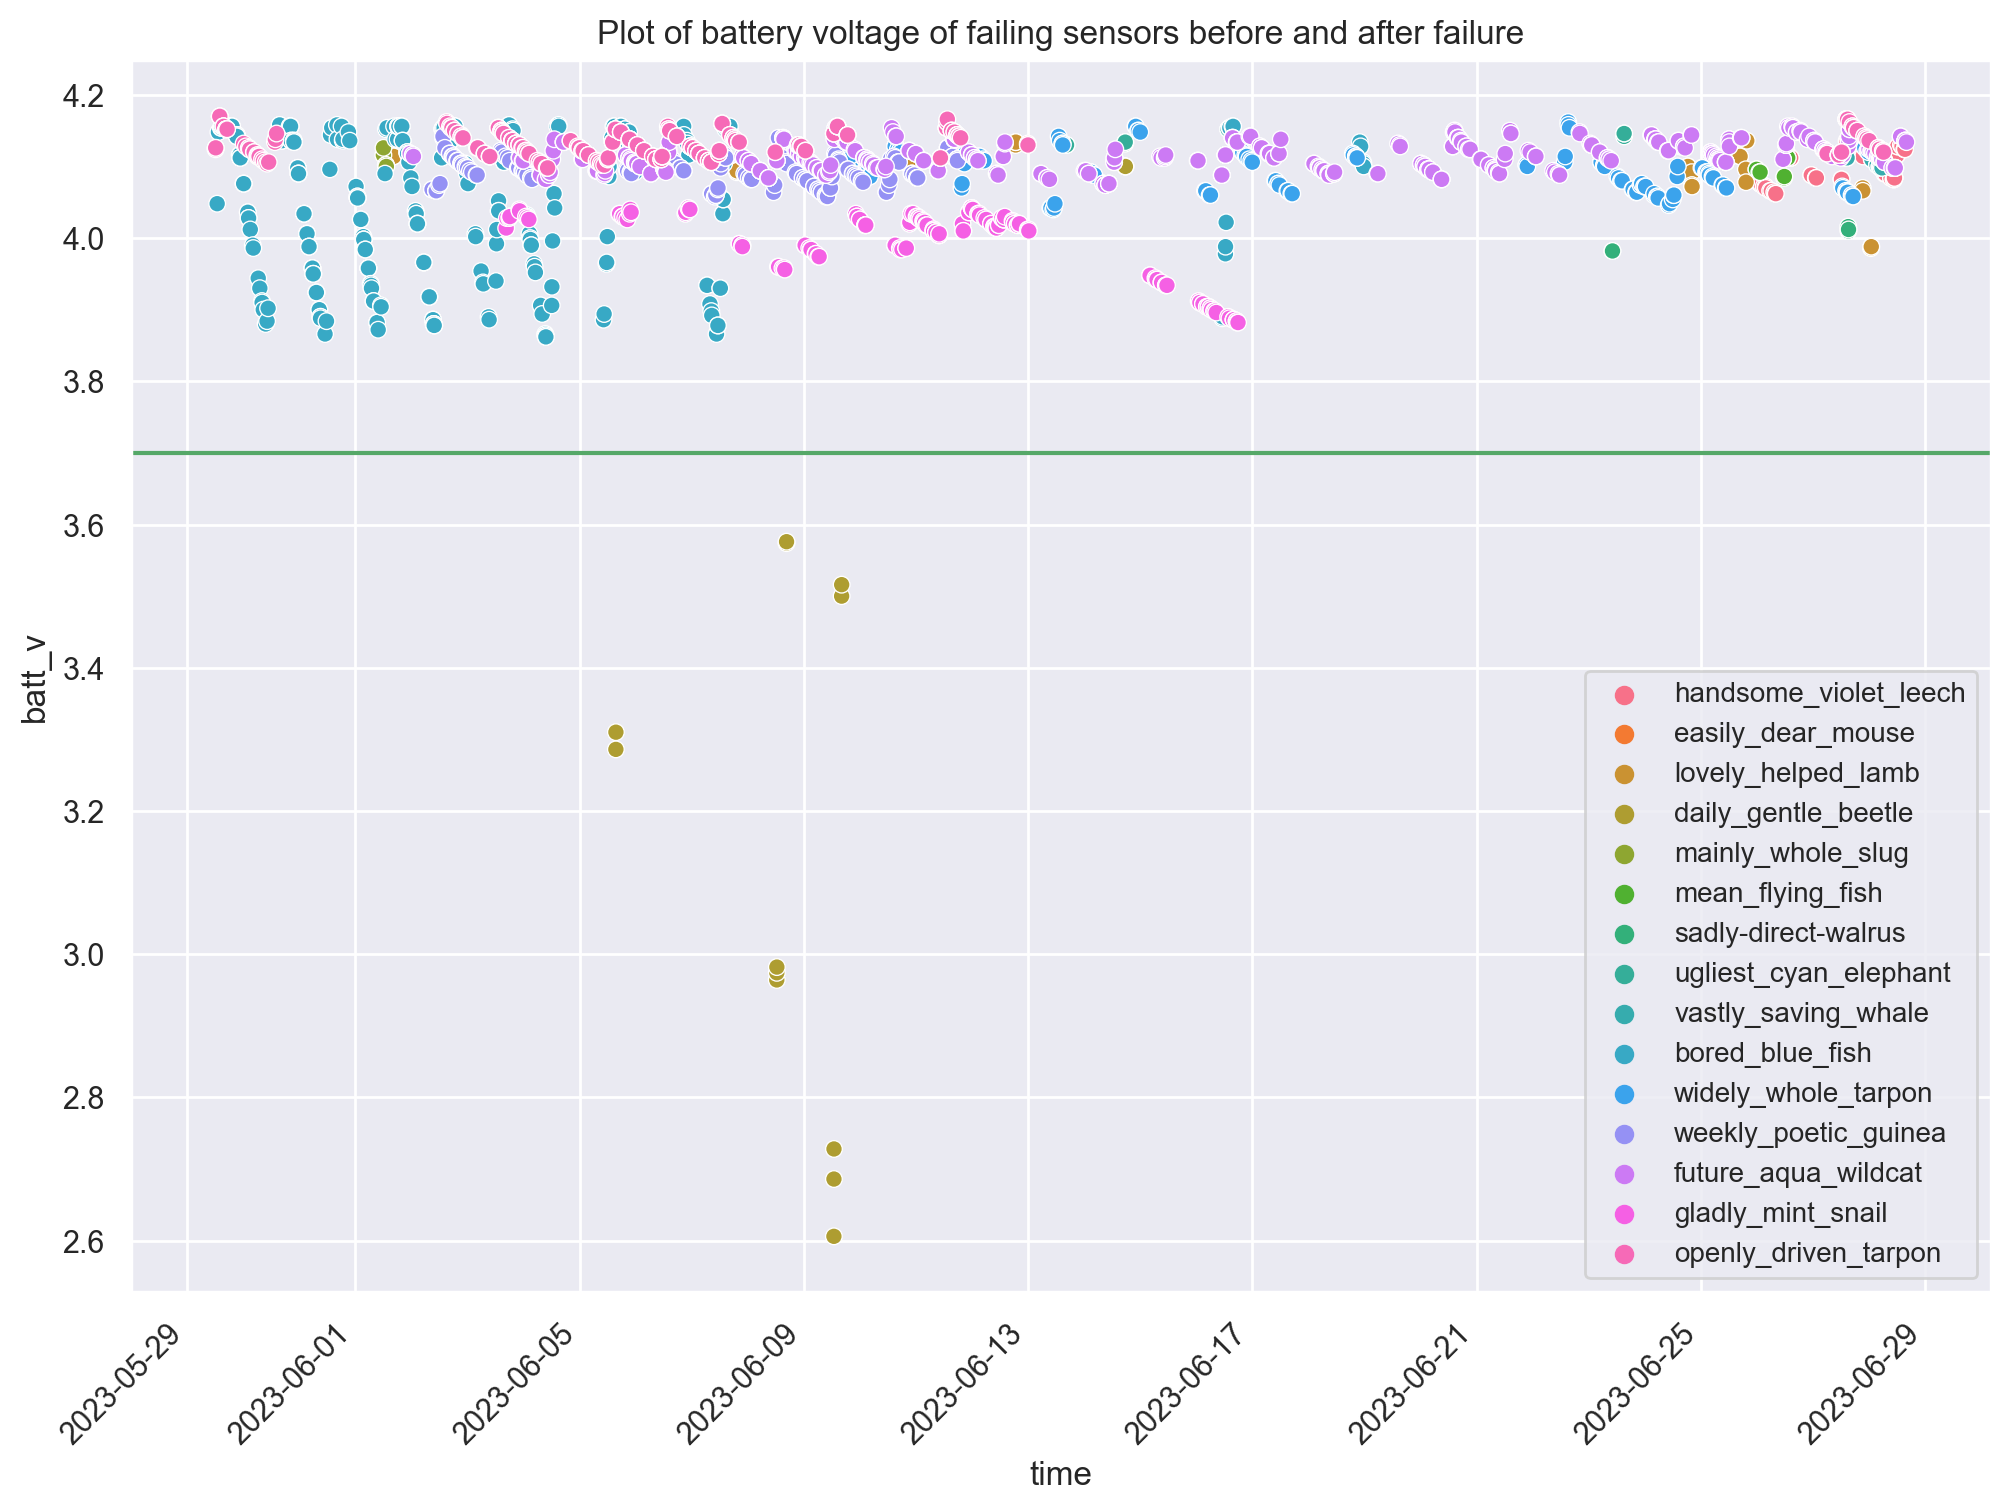

In [115]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.scatterplot(data = big_fail, x = 'time', y = 'batt_v', hue = 'deployment_id')
plt.xticks(rotation=45, ha='right')
plt.title('Plot of battery voltage of failing sensors before and after failure')
plt.legend(fontsize='small', loc='lower right')
plt.axhline(y=3.7, color = 'g')
plt.show()